# Sistema de Recomendación de Películas

Este notebook crea un sistema de recomendación que sugiere películas del Top 250 de IMDB basado en:
- Ratings personales en Letterboxd
- Año de la película
- Géneros
- Actores involucrados
- Directores

## 1. Configuración Inicial
Primero, instalamos e importamos las librerías necesarias.

In [ ]:
# Instalación de paquetes (ejecutar solo una vez)
!pip install imdbpy scikit-learn pandas numpy matplotlib seaborn

In [1]:
# Importaciones
import pandas as pd
import numpy as np
from imdb import IMDb
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings

# Configuración
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")
ia = IMDb()

## 2. Carga de Datos

Cargamos tus ratings de Letterboxd y el Top 250 de IMDB.

**Nota**: Se asume que se tienen estos archivos CSV.

In [16]:
def cargar_datos():
    """Carga y prepara los datasets"""
    # Cargar tus ratings de Letterboxd (ajusta los nombres de columnas)
    letterboxd = pd.read_csv('letterboxd_ratings.csv')
    letterboxd = letterboxd.rename(columns={
        'Name': 'title',
        'Year': 'year',
        'Rating': 'rating'
    })

    # Cargar Top 250 de IMDB (puedes generarlo con imdbpy si no tienes el CSV)
    imdb_top = pd.read_csv('imdb_top250.csv')
    imdb_top = imdb_top.rename(columns={
        'name': 'title',
        'year': 'year',
        'rating': 'imdb_rating'
    })

    return letterboxd, imdb_top

In [17]:
letterboxd_ratings, imdb_top250 = cargar_datos()

## 3. Enriquecimiento de Datos

Vamos a obtener información adicional de IMDB para las películas calificadas.

In [18]:
def obtener_info_imdb(title, year):
    """Obtiene datos de IMDB con manejo de errores y caché"""
    try:
        resultados = ia.search_movie(f"{title} {year}")
        if not resultados:
            return None

        pelicula = ia.get_movie(resultados[0].movieID)

        return {
            'title': pelicula.get('title', title),
            'year': pelicula.get('year', year),
            'imdb_rating': pelicula.get('rating', np.nan),
            'genres': pelicula.get('genres', []),
            'directors': [d['name'] for d in pelicula.get('directors', [])],
            'actors': [a['name'] for a in pelicula.get('actors', [])[:3]],
            'runtime': pelicula.get('runtime', [0])[0] if pelicula.get('runtime') else 0
        }
    except Exception:
        return None

In [19]:
def enriquecer_fila(fila, es_letterboxd):
    """Enriquece una fila con datos de IMDb"""
    info = obtener_info_imdb(str(fila['title']), fila['year'])
    if info and es_letterboxd:
        info['user_rating'] = fila['rating']
    return info

In [20]:
def enriquecer_datos(df, es_letterboxd=True, max_workers=15):
    """Añade datos de IMDB a un DataFrame usando concurrencia"""
    datos_enriquecidos = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futuros = {executor.submit(enriquecer_fila, fila, es_letterboxd): fila for _, fila in df.iterrows()}
        for futuro in tqdm(as_completed(futuros), total=len(futuros)):
            resultado = futuro.result()
            if resultado:
                datos_enriquecidos.append(resultado)
    return pd.DataFrame(datos_enriquecidos)

In [21]:
# Enriquecer datos
print("\nEnriqueciendo tus ratings de Letterboxd...")
letterboxd_enriched = enriquecer_datos(letterboxd_ratings)

print("\nEnriqueciendo Top 250 de IMDB...")
imdb_enriched = enriquecer_datos(imdb_top250, es_letterboxd=False)

# Mostrar resultados
print(f"\nPelículas enriquecidas: {len(letterboxd_enriched)}/{len(letterboxd_ratings)}")
display(letterboxd_enriched.head(2))


Enriqueciendo tus ratings de Letterboxd...


100%|██████████| 104/104 [00:50<00:00,  2.06it/s]



Enriqueciendo Top 250 de IMDB...


100%|██████████| 250/250 [01:52<00:00,  2.21it/s]


Películas enriquecidas: 104/104


,title,year,imdb_rating,genres,directors,actors,runtime,user_rating
0,Grave of the Fireflies,1988,8.5,"[Animation, Drama, War]",[Isao Takahata],"[Tsutomu Tatsumi, Ayano Shiraishi, Yoshiko Shi...",88,5.0
1,Akira,1988,8.0,"[Animation, Drama, Fantasy, Sci-Fi]",[Katsuhiro Ôtomo],"[Mitsuo Iwata, Nozomu Sasaki, Mami Koyama]",124,5.0


In [22]:
# Filtrar las películas del top 250 que ya estén en el historial de Letterboxd
watched_movies = imdb_enriched[imdb_enriched['title'].isin(letterboxd_enriched['title'])]

unwatched_movies = imdb_enriched[~imdb_enriched['title'].isin(letterboxd_enriched['title'])]

## 4. Preprocesamiento de Datos

In [23]:
mlb_genres = MultiLabelBinarizer()
mlb_directors = MultiLabelBinarizer()
mlb_actors = MultiLabelBinarizer()

letterboxd_enriched['genres'] = letterboxd_enriched['genres'].apply(lambda x: x if isinstance(x, list) else eval(x))
letterboxd_enriched['directors'] = letterboxd_enriched['directors'].apply(lambda x: x if isinstance(x, list) else eval(x))
letterboxd_enriched['actors'] = letterboxd_enriched['actors'].apply(lambda x: x if isinstance(x, list) else eval(x))

imdb_enriched['genres'] = imdb_enriched['genres'].apply(lambda x: x if isinstance(x, list) else eval(x))
imdb_enriched['directors'] = imdb_enriched['directors'].apply(lambda x: x if isinstance(x, list) else eval(x))
imdb_enriched['actors'] = imdb_enriched['actors'].apply(lambda x: x if isinstance(x, list) else eval(x))


In [24]:
# Preparar las características (features) y la variable objetivo (target) para las películas no vistas
X_train = np.hstack([
    mlb_genres.fit_transform(letterboxd_enriched['genres']),
    mlb_directors.fit_transform(letterboxd_enriched['directors']),
    mlb_actors.fit_transform(letterboxd_enriched['actors']),
    letterboxd_enriched[['year', 'imdb_rating']].values
])
y_train = letterboxd_enriched['user_rating'].values

## 5. Modelado y Recomendación

In [25]:
# Entrenar el modelo
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [26]:
# Predecir en películas no vistas del Top 250 IMDb
X_test = np.hstack([
    mlb_genres.transform(unwatched_movies['genres']),
    mlb_directors.transform(unwatched_movies['directors']),
    mlb_actors.transform(unwatched_movies['actors']),
    unwatched_movies[['year', 'imdb_rating']].values
])

In [27]:
y_pred = model.predict(X_test)
unwatched_movies['predicted_rating'] = y_pred
recommendations = unwatched_movies.sort_values(by='predicted_rating', ascending=False).head(100)

## 6. Visualización de datos

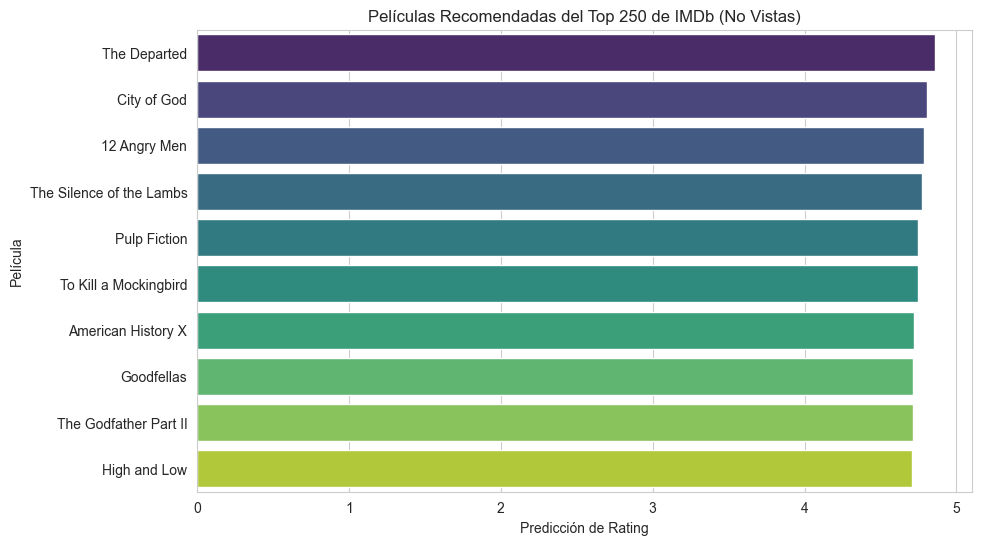

In [28]:
# Visualización de las recomendaciones
plt.figure(figsize=(10, 6))
sns.barplot(x='predicted_rating', y='title', data=recommendations.head(10), palette='viridis')
plt.title('Películas Recomendadas del Top 250 de IMDb (No Vistas)')
plt.xlabel('Predicción de Rating')
plt.ylabel('Película')
plt.show()

## 7. Exportación de datos

In [29]:
recommendations.to_excel('recomendaciones_random_forest_no_vistas.xlsx', index=False)
print("Recomendaciones guardadas en recomendaciones_random_forest_no_vistas.xlsx")

Recomendaciones guardadas en recomendaciones_random_forest_no_vistas.xlsx
